<a href="https://colab.research.google.com/github/rbutronelectrosof/Utilidades/blob/main/fotosSIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyvo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
from getpass import getpass
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io
from astropy.visualization import make_lupton_rgb
%matplotlib inline

#importo librerias para graficar 2-parte
from numpy.core.defchararray import startswith, count
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS


# para logearse en SM
#from dl import authClient as ac, queryClient as qc
#from dl.helpers.utils import convert
#from dl import storeClient as sc


# To get image cutouts, you'll need the VO-based SIA package, and define which SIA service to use
from pyvo.dal import sia
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr1" # DES SIA service URL
svc = sia.SIAService(DEF_ACCESS_URL)

# token de autenticacion
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))
#ac.whoAmI()

##CARGO COORDENADAS

In [ ]:
# NGC 288 (a globular cluster) , inserto el cluster que quiero buscar


ra =90.258  # in decimal degrees
dec =-73.274  # in decimal degrees
fov = 3/60   # image cutout field of view (in degrees; here 13 arminutes = 0.22 degrees)

#le tiro cordenadas a segunda parte
ra2 = ra
dec2 = dec
fov2 = fov

imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()  # uses declination correction

print(type(imgTable))
#imgTable

<class 'astropy.table.table.Table'>


In [ ]:
# selecciono solo las imagenes del filtro g
sel0 = imgTable['obs_bandpass'] == 'g'

# logically add selections for 'Stack' and 'image' product type
sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection

Table = imgTable[sel] # select
Table

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20160217t034943,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_160217_035131_osi_g_v1.fits.fz&extn=5&POS=90.258,-73.274&SIZE=0.17373469420399607,0.05",image/fits,393235,,,3,0,0,2,[24 9074],,,[0.26551],,ct4m20160217t034943,,2013B-0440,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_nsa.siav1:ivo://datalab.noao//c4d_160217_035131_osi_g_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_160217_035131_osi_g_v1.fits.fz&extn=5&POS=90.258,-73.274&SIZE=0.17373469420399607,0.05&preview=true",,,89.8977,-73.4305,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,Field226,1.51,2013B-0440,28.521,image,0,5.29723,,120,,Stack,2016-02-17T03:49:43.240355,557435.15952824,0


#extraigo la imagen de la URL

In [ ]:
    row = Table[0]
    url = row['access_url'] # get the download URL
    print(url)
    gimage = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))


https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_160217_035131_osi_g_v1.fits.fz&extn=5&POS=90.258,-73.274&SIZE=0.17373469420399607,0.05


# grafico la imagen del sector

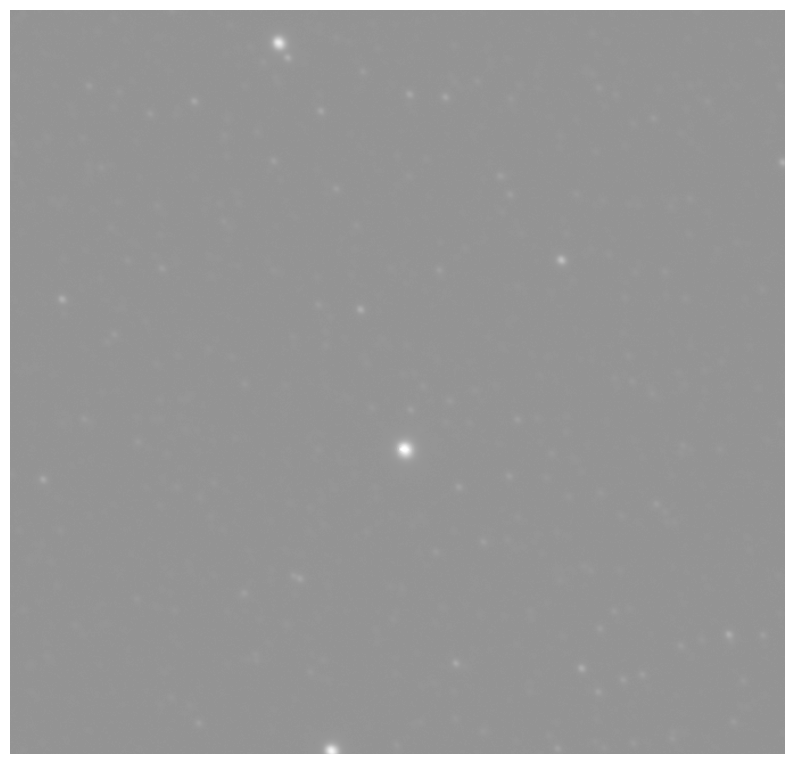

In [ ]:
fig = plt.subplots(figsize=(10,10))
plt.imshow(np.arcsinh(gimage),cmap='gray',norm=matplotlib.colors.Normalize(vmin=0))
plt.axis('off');

#coloreo la imagen con los distintos filtros

In [ ]:
def download_deep_stack(ra,dec,fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    print("The full image list contains", len(imgTable), "entries")

    # apply image seletion criteria
    sel0 = imgTable['obs_bandpass'] == band
    sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection
    Table = imgTable[sel] # select

    # if more than one image matches our desired criteria
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print ('Downloading deepest stacked image...')
        image = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))
        print(url)

    else:
        print ('No existe la imagen')
        image = None

    print()
    return image

In [ ]:
#coloco los filtros que deseo

rimage = download_deep_stack(ra,dec,fov,band='r')
iimage = download_deep_stack(ra,dec,fov,band='i')
uimage = download_deep_stack(ra,dec,fov,band='u')
zimage = download_deep_stack(ra,dec,fov,band='z')
#gimage = download_deep_stack(ra,dec,fov,band='g')

#solo grafica RGB o sus convinaciones en otros filtros !!!!!!!!!!!!!!!!!!!!!!!!
#color_image = make_lupton_rgb(uimage, rimage, gimage, stretch=100, Q=0.1)

color_image = make_lupton_rgb(iimage, rimage, gimage, stretch=100, Q=0.1)

The full image list contains 0 entries
No existe la imagen

The full image list contains 0 entries
No existe la imagen

The full image list contains 0 entries
No existe la imagen

The full image list contains 0 entries
No existe la imagen



ValueError: The image shapes must match. r: (), g: () b: (654, 681)

In [ ]:
#grafico
fig = plt.figure(figsize=(10,10))

plt.imshow(color_image)
plt.axis('off');

NameError: name 'color_image' is not defined

<Figure size 1000x1000 with 0 Axes>

## NASA


In [ ]:
 #tabla  SIA nsa
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/nsa"
svc_nsa = sia.SIAService(DEF_ACCESS_URL)
#ra = 2.7
#dec = -59
#fov = 0.1


ra = ra2
dec = dec2
fov = fov2

imgTable = svc_nsa.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

# ploteo multiple imagen
def plot_images(images,geo=None,panelsize=5,titles=list('gri'),cmap=plt.cm.gray_r):
    if geo is None:
        geo = (len(images),1)  # ncols, nrows

    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.1))
        ax.set_title('{:s}'.format(titles[j]))
        plt.axis('off')

#Right now we have it set so that the g and i images are moved 8 pixels to the left
a=0
b=8

In [ ]:
# selecciono solo las imagenes del filtro g
sel0 = imgTable['obs_bandpass'] == 'g'

# logically add selections for 'Stack' and 'image' product type
sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection

Table = imgTable[sel] # select
#Table

In [ ]:
row = Table[0]
url = row['access_url'] # get the download URL
print(url)
gimage = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))

https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_160217_035131_osi_g_v1.fits.fz&extn=5&POS=90.258,-73.274&SIZE=0.17373469420399607,0.05


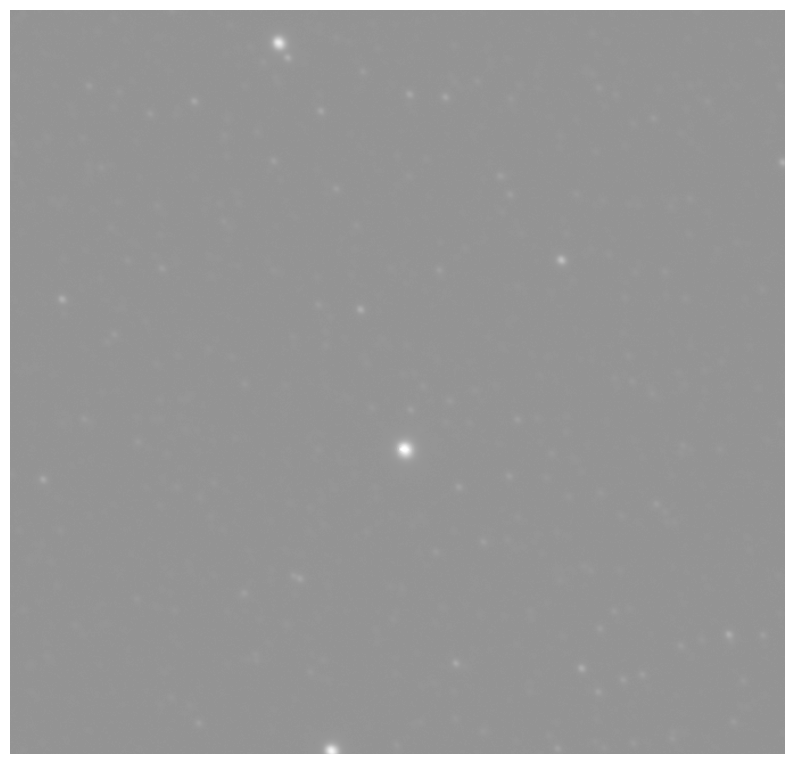

In [ ]:
fig = plt.subplots(figsize=(10,10))
plt.imshow(np.arcsinh(gimage),cmap='gray',norm=matplotlib.colors.Normalize(vmin=0))
plt.axis('off');

In [ ]:
#imprimo imagen en filtro g

sel = (imgTable['proctype'].astype(str)=='InstCal') & (imgTable['prodtype'].astype(str)=='image') & (imgTable['access_estsize'].astype(str)=='311551') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'g'))
#print(imgTable[sel][0])

row = imgTable[sel][0]
url = row['access_url'] # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
i1 = hdu.data
hdr = hdu.header
wcs = WCS(hdr)
#Dimensions of each image need to be equal
image1 = i1[0:1362, b:1233]
#Normalization
#image1 *= (10.0**(0.4*(30.0 - zpt)))/exptime
#from header, exptime=85, expnum=188187, ccdnum=16
zp=31.514652
image1 *= (10.0**(0.4*(30.0-zp)))/hdr["EXPTIME"]

IndexError: index 0 out of range for table with length 0